In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

import sys
import re
import json
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn
from scipy import signal
import ddddocr

In [2]:
pf = pd.DataFrame(os.listdir(os.path.join("source", "data")), columns=["filename"])
pf

filename
0   btn_gift.png
1      frame.jpg
2     frame2.jpg
3     frame3.jpg
4       main.png
5      main2.png
6       page.png
7    receive.png
8       side.png
9      side2.png
10     side3.png

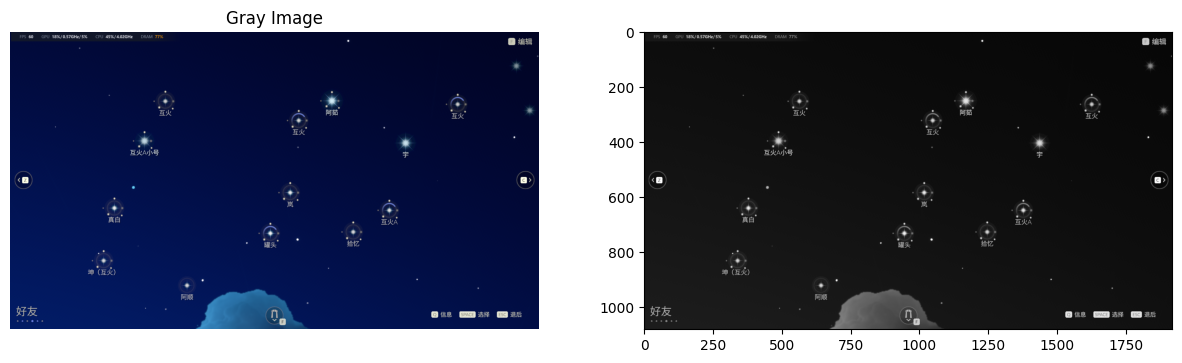

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# 读取一下图片进行测试
image = cv2.imread(os.path.join("source", "data", "side.png"))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

axes[0].imshow(image)
axes[0].axis('off')
axes[0].set_title("Origin Image")
axes[1].imshow(gray, cmap="gray")
axes[0].axis('off')
axes[0].set_title("Gray Image")
plt.show()

---
# 直接对灰度图进行霍夫变换

效果比滤波之后的强很多, 游戏界面不需要怎么滤波, 注意不要有其他陌生人就行

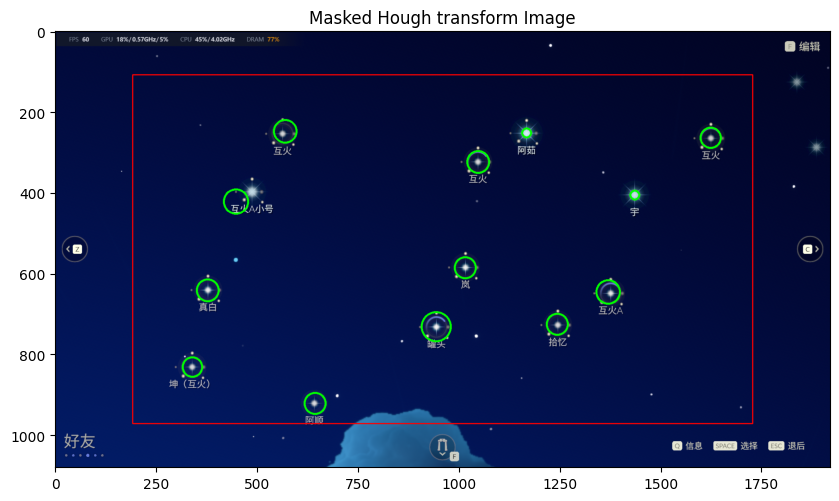

In [4]:
min_radius=1
max_radius=100

# 边界去除
height, width = gray.shape
border_ratio = 0.1
mask = np.zeros_like(gray, dtype=np.uint8)
border_x = int(width * border_ratio)
border_y = int(height * border_ratio)
inner_width = width - 2 * border_x
inner_height = height - 2 * border_y

cv2.rectangle(mask, (border_x, border_y), (border_x + inner_width, border_y + inner_height), 255, -1)
masked_edges = cv2.bitwise_and(mask, gray, mask=mask)

# 使用霍夫圆变换检测圆形
circles = cv2.HoughCircles(
    masked_edges,               # 输入图像（边缘图）
    cv2.HOUGH_GRADIENT,         # 检测方法（梯度法）
    dp=1,                       # 累加器图像的分辨率与原图之比
    minDist=50,                 # 检测到的圆的圆心之间的最小距离
    param1=50,                  # Canny边缘检测器的高阈值
    param2=30,                  # 累加器阈值（越小检测到的圆越多）
    minRadius=min_radius,       # 最小圆半径
    maxRadius=max_radius        # 最大圆半径
)

# 复制原图用于绘制结果
result = image.copy()
cv2.rectangle(result, (border_x, border_y), (border_x + inner_width, border_y + inner_height), 255, 2)

if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    for (x, y, r) in circles:
        cv2.circle(result, (x, y), r, (0, 255, 0), 4)
else:
    print("No detection.")


fig, axes = plt.subplots(1, 1, figsize=(10, 6))
axes.imshow(result, cmap="gray")
axes.set_title("Masked Hough transform Image")
plt.show()

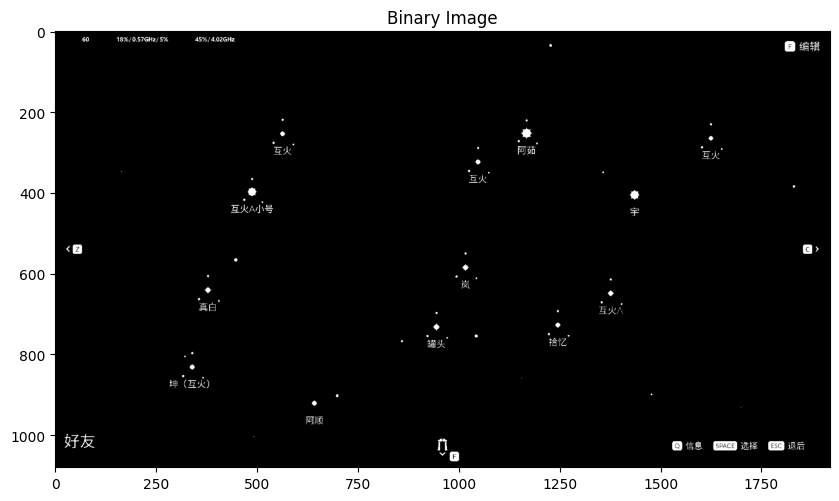

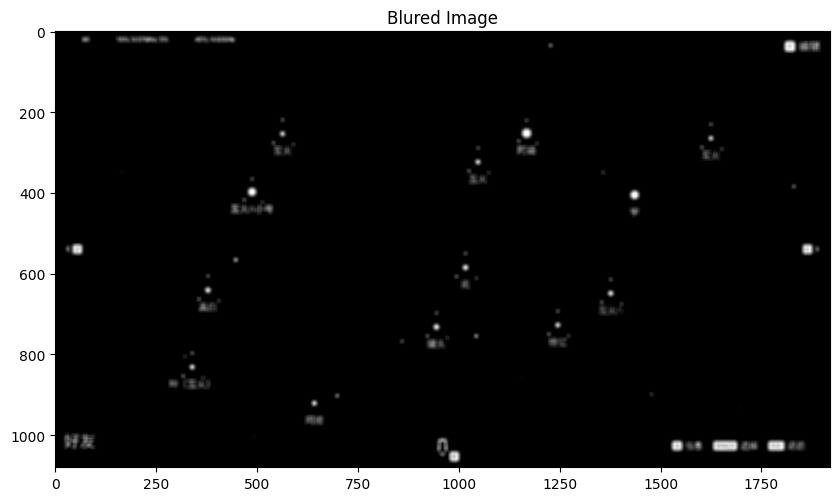

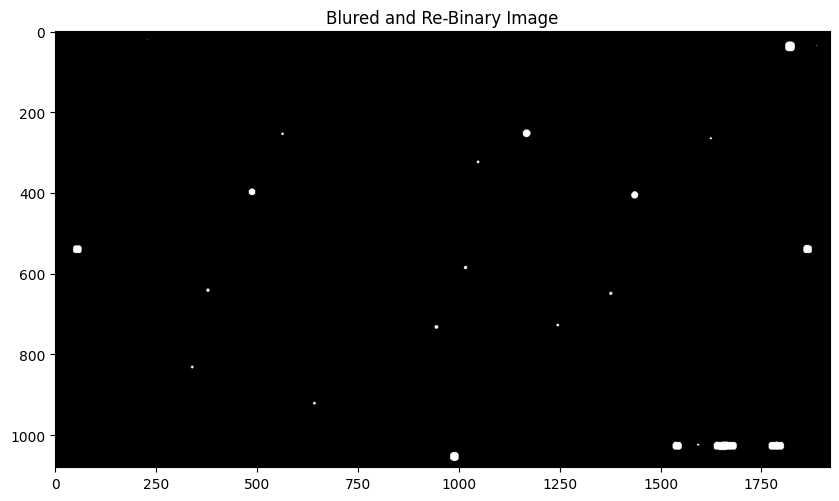

In [5]:
# 对灰度图进行二值化
_, binary_image = cv2.threshold(gray, 155, 255, cv2.THRESH_BINARY)
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
axes.imshow(binary_image, cmap="gray")
axes.set_title("Binary Image")
plt.show()

# 高斯平滑后再采样
blured_image = cv2.blur(binary_image, (11,11))
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
axes.imshow(blured_image, cmap="gray")
axes.set_title("Blured Image")
plt.show()

# 重新二值化采样
_, rebinary_image = cv2.threshold(blured_image, 155, 255, cv2.THRESH_BINARY)
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
axes.imshow(rebinary_image, cmap="gray")
axes.set_title("Blured and Re-Binary Image")
plt.show()

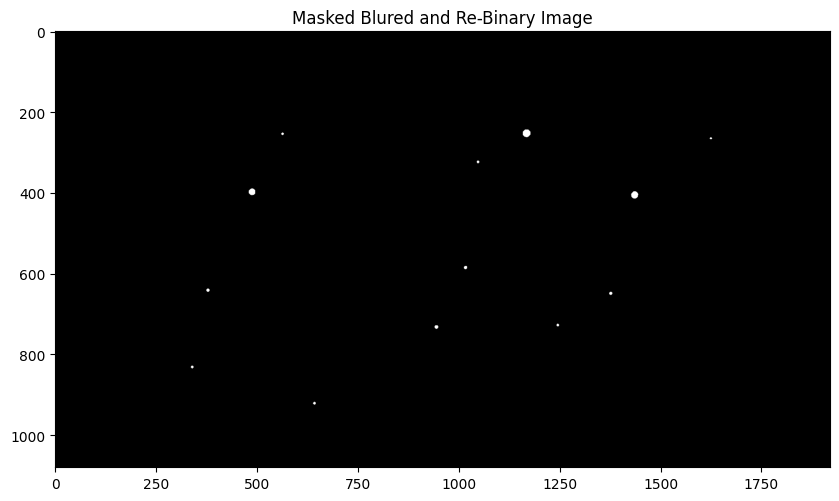

In [6]:
# 掩膜
height, width = gray.shape
border_ratio = 0.1
mask = np.zeros_like(gray, dtype=np.uint8)
border_x = int(width * border_ratio)
border_y = int(height * border_ratio)
inner_width = width - 2 * border_x
inner_height = height - 2 * border_y

cv2.rectangle(mask, (border_x, border_y), (border_x + inner_width, border_y + inner_height), 255, -1)
masked_rebinary_image = cv2.bitwise_and(mask, rebinary_image, mask=mask)

fig, axes = plt.subplots(1, 1, figsize=(10, 6))
axes.imshow(masked_rebinary_image, cmap="gray")
axes.set_title("Masked Blured and Re-Binary Image")
plt.show()

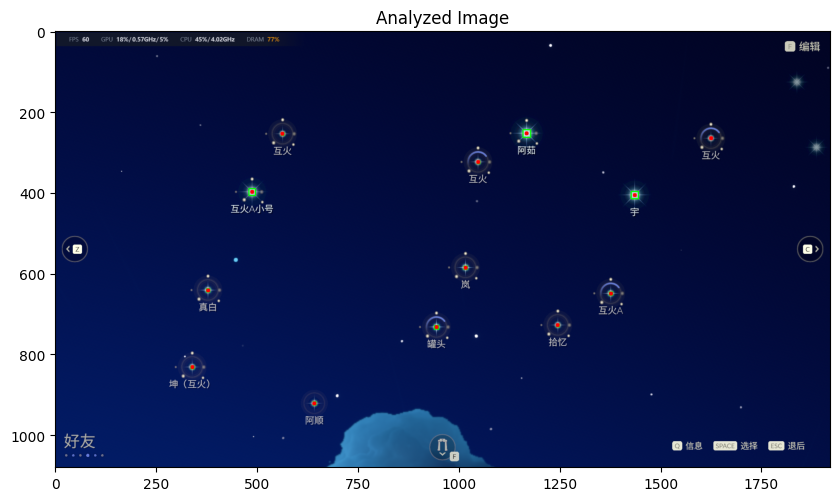

In [7]:
# 提取大范围亮色特征 (轮廓分析)
targets = []
origin_image = image.copy()
contours, _ = cv2.findContours(masked_rebinary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    center_x = x + w // 2
    center_y = y + h // 2
    targets.append((center_x, center_y))
    
    cv2.rectangle(origin_image, (x, y), (x+w, y+h), (0, 255, 0), 2)  # 绿色矩形
    cv2.circle(origin_image, (center_x, center_y), 5, (255, 0, 0), -1)  # 红色点

fig, axes = plt.subplots(1, 1, figsize=(10, 6))
axes.imshow(origin_image)
axes.set_title("Analyzed Image")
plt.show()

---
# FFT 滤波

高斯滤波器的算法是这样的 $ G(x,y) = e^{-\frac{x^2+y^2}{\sigma^2}} $，我们对它取减法就获得了高通滤波器

归一化算法 $ V_{new} = \frac{V_{old} - min(V_{olds})}{max(V_{olds}) - min(V_{olds})} \times 255 $

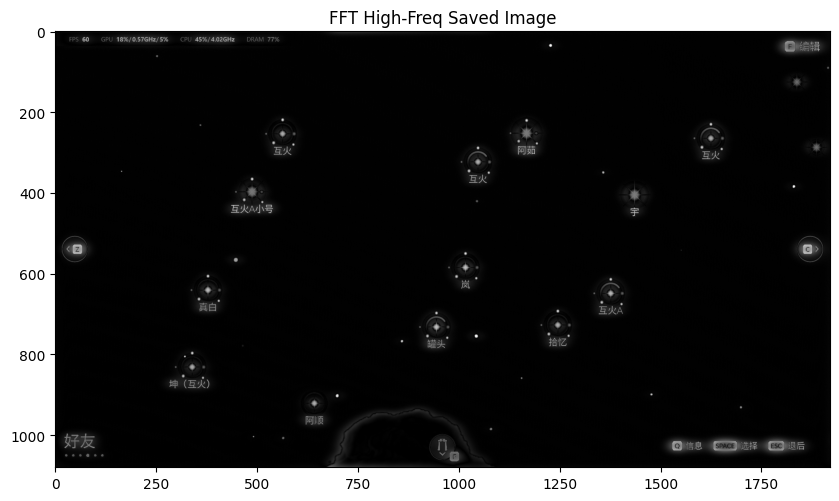

In [8]:
# 二维快速傅里叶变换, 抑制低频信号
f = np.fft.fft2(gray)
f_shift = np.fft.fftshift(f)

rows, cols = gray.shape
crow, ccol = rows//2, cols//2

sigma = 20
# 创建二维坐标网格，计算每个点到图像中心的偏移量
y, x = np.ogrid[-crow:rows-crow, -ccol:cols-ccol]
mask_gaussian_high = 1 - np.exp(-(x*x + y*y)/(2*sigma**2))

# 与掩码相乘实现滤波
f_filtered_high = f_shift * mask_gaussian_high

# 逆中心化、FFT 逆变换、有理化
f_ishift_high = np.fft.ifftshift(f_filtered_high)
img_filtered_high = np.fft.ifft2(f_ishift_high)
img_filtered_high = np.abs(img_filtered_high)

# 像素值归一化后整数化
fft_image = np.uint8(cv2.normalize(img_filtered_high, None, 0, 255, cv2.NORM_MINMAX))

fig, axes = plt.subplots(1, 1, figsize=(10, 6))
axes.imshow(fft_image, cmap="gray")
axes.set_title("FFT High-Freq Saved Image")
plt.show()

---
# Canny 算子边缘提取

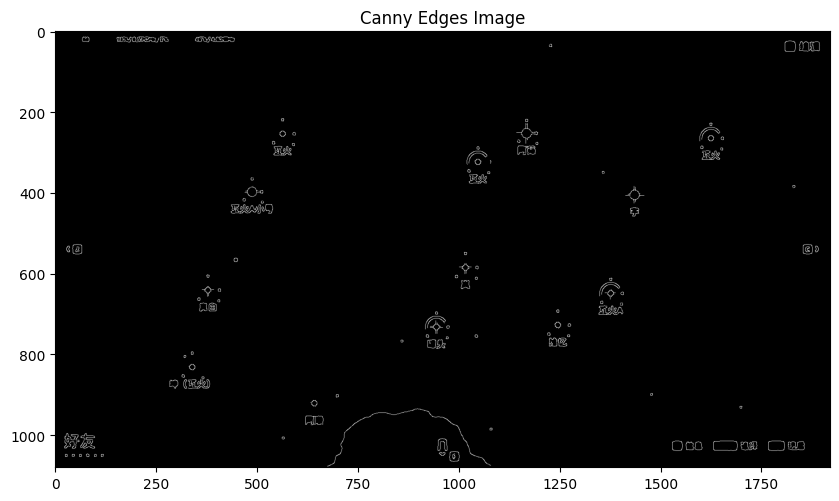

In [9]:
canny_threshold1=50
canny_threshold2=150

# 高斯模糊并边缘化
blurred = cv2.GaussianBlur(gray, (9, 9), 2)
edges = cv2.Canny(blurred, canny_threshold1, canny_threshold2)

fig, axes = plt.subplots(1, 1, figsize=(10, 6))
axes.imshow(edges, cmap="gray")
axes.set_title("Canny Edges Image")
plt.show()

---
# ddddocr 文字提取获取星盘状态


OCR 识别结果: 好友 [20, 23, 60, 61] [60, 22, 99, 61]


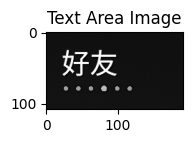

In [10]:
ocr = ddddocr.DdddOcr(show_ad=False)
text_detector = ddddocr.DdddOcr(det=True, show_ad=False)

# 边界去除
height, width = gray.shape
border_ratio = 0.1
mask = np.zeros_like(gray, dtype=np.uint8)
border_x = int(width * border_ratio)
border_y = int(height * border_ratio)

text_area = gray[height-border_y:, :border_x]

fig, axes = plt.subplots(1, 1, figsize=(3, 1))
axes.imshow(text_area, cmap='gray')
axes.set_title("Text Area Image")

_, encoded_img = cv2.imencode('.png', text_area)
img_bytes = encoded_img.tobytes()

result = ocr.classification(img_bytes)
det = text_detector.detection(img_bytes)

print("\nOCR 识别结果:", result , ' '.join([str(det) for det in det]))

---
# 正则表达式匹配规则

In [11]:
def re_keyword_detector(texts):
    """
    ASCII字符清洗检测子串, 子串是提前规定好的
    """
    patterns = [r'添[\x00-\x7F]{0,3}加[\x00-\x7F]{0,3}好[\x00-\x7F]{0,3}友', r'好[\x00-\x7F]{0,3}友', r'挚[\x00-\x7F]{0,3}友']
    dataframes = {
        '识别文本': [],
        '星盘页': [],
        '添加好友': [],
        '好友': [],
        '挚友': [],
    }

    for text in texts:
        matchs = list([bool(re.search(pattern, text)) for pattern in patterns])
        dataframes['星盘页'].append(True in matchs)
        dataframes['添加好友'].append(matchs[0] == True)
        dataframes['好友'].append(matchs[1] == True)
        dataframes['挚友'].append(matchs[2] == True)
        dataframes['识别文本'].append(text)
        
    return pd.DataFrame(dataframes)

texts = ['你好', '添加好友，同意一下', '好$友', '']

pf = re_keyword_detector(texts)
pf

识别文本    星盘页   添加好友     好友     挚友
0         你好  False  False  False  False
1  添加好友，同意一下   True   True   True  False
2        好$友   True  False   True  False
3             False  False  False  False

---
# 检测我们需要送心火的目标

In [12]:
# 全局配置
# sns.set_theme(style="darkgrid", palette="pastel")
ocr = ddddocr.DdddOcr(show_ad=False)
size_info = []

# 二值化检测器
def threhold_detector(gray, plot=False, show=False):
    '''
    使用灰度化和高斯模糊确定目标点, FFT 和 Canny 算子都太不稳定了
    '''
    # 对灰度图进行二值化
    _, binary_image = cv2.threshold(gray, 155, 255, cv2.THRESH_BINARY)
    # 高斯平滑后再采样
    blured_image = cv2.blur(binary_image, (11,11))
    # 重新二值化采样
    _, rebinary_image = cv2.threshold(blured_image, 155, 255, cv2.THRESH_BINARY)
    
    # 掩膜
    height, width = gray.shape
    border_ratio = 0.1
    mask = np.zeros_like(gray, dtype=np.uint8)
    border_x = int(width * border_ratio)
    border_y = int(height * border_ratio)
    inner_width = width - 2 * border_x
    inner_height = height - 2 * border_y

    cv2.rectangle(mask, (border_x, border_y), (border_x + inner_width, border_y + inner_height), 255, -1)
    masked_rebinary_image = cv2.bitwise_and(mask, rebinary_image, mask=mask)
    
    # 提取大范围亮色特征 (轮廓分析)
    targets = []
    origin_image = None
    if plot:
        origin_image = image.copy()
        cv2.rectangle(origin_image, (border_x, border_y), (border_x + inner_width, border_y + inner_height), 255, 2)
    
    contours, _ = cv2.findContours(masked_rebinary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        center_x, center_y = x + w // 2, y + h // 2
        targets.append((center_x, center_y, w, h))
        
        if plot:
            cv2.rectangle(origin_image, (x, y), (x+w, y+h), (0, 255, 0), 2)  # 绿色矩形
            cv2.circle(origin_image, (center_x, center_y), 5, (255, 0, 0), -1)  # 红色点

    if show:
        fig, axes = plt.subplots(1, 1, figsize=(10, 6))
        axes.imshow(origin_image)
        axes.set_title("Analyzed Image")
        plt.show()
    
    return targets, origin_image

# 圆形检测器
def hough_detector(gray, plot=False, show=False):
    '''
    使用霍夫变换检测圆形目标, 主要提供我们的识别区域
    '''
    min_radius=1
    max_radius=35

    # 边界去除
    height, width = gray.shape
    border_ratio = 0.1
    mask = np.zeros_like(gray, dtype=np.uint8)
    border_x = int(width * border_ratio)
    border_y = int(height * border_ratio)
    inner_width = width - 2 * border_x
    inner_height = height - 2 * border_y

    cv2.rectangle(mask, (border_x, border_y), (border_x + inner_width, border_y + inner_height), 255, -1)
    masked_edges = cv2.bitwise_and(mask, gray, mask=mask)

    # 使用霍夫圆变换检测圆形
    circles = cv2.HoughCircles(
        masked_edges,               # 输入图像（边缘图）
        cv2.HOUGH_GRADIENT,         # 检测方法（梯度法）
        dp=1,                       # 累加器图像的分辨率与原图之比
        minDist=50,                 # 检测到的圆的圆心之间的最小距离
        param1=50,                  # Canny边缘检测器的高阈值
        param2=25,                  # 累加器阈值（越小检测到的圆越多）
        minRadius=min_radius,       # 最小圆半径
        maxRadius=max_radius        # 最大圆半径
    )

    # 复制原图用于绘制结果
    origin_image = None
    if plot:
        origin_image = image.copy()
        cv2.rectangle(origin_image, (border_x, border_y), (border_x + inner_width, border_y + inner_height), 255, 2)

    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        if plot:
            for (x, y, r) in circles:
                cv2.circle(origin_image, (x, y), r, (0, 255, 0), 4)
    else:
        print("No detection.")
        
    if show:
        fig, axes = plt.subplots(1, 1, figsize=(10, 6))
        axes.imshow(origin_image, cmap="gray")
        axes.set_title("Masked Hough transform Image")
        plt.show()
        
    return circles, origin_image

def gradient_detector(arr):
    """
    一阶离散梯度寻找切割平面
    """
    global size_info
    # 数据太少直接使用旧值, 所以我们检测的时候一定要从数据多的一侧开始检测
    if arr.shape[0] < 4:
        # 直接返回超平面平均值
        if len(size_info) > 0:
            return False, np.mean(size_info), None
        else:
            # 吓人的三无数据
            return False, None, None
        
    abs_gradients = np.abs(np.diff(arr))
    idx = np.argmax(abs_gradients)

    # 切割超平面
    split_surface = np.mean(arr[idx:idx+2])
    # 平均梯度统计
    explore = np.ones((abs_gradients.shape[0]+2,))*np.mean(abs_gradients)
    explore[1:-1] = abs_gradients
    output = signal.medfilt(explore, kernel_size=3) # 等宽中值滤波, 两边补平均值
    mean_gradients = np.mean(output)

    # 如果最大梯度与平均梯度的变化不足 50%
    if abs(split_surface-mean_gradients)/mean_gradients < 0.5:
        return False, split_surface, mean_gradients
    else:
        size_info.append(split_surface)
        return True, split_surface, mean_gradients

# 双因素检测器
def tfa_detector(gray, plot=False, show=False):
    '''
    TWO FACTOR 双因素检测器, 结合阈值检测器和霍夫变换检测器
    '''
    targets, _ = threhold_detector(gray)
    circles, _ = hough_detector(gray)

    if targets is None or circles is None:
        return [], None

    target_array = np.array(targets)       # 形状: (n_targets, 4)
    circles_array = np.array(circles)      # 形状: (n_circles, 3)

    target_centers = target_array[:, :2]   # 形状: (n_targets, 2)
    circle_centers = circles_array[:, :2]  # 形状: (n_circles, 2)

    circle_radius = circles_array[:, 2].reshape(1, -1)  # 形状: (1, n_circles)
    
    # 计算所有目标中心与所有圆心之间的距离矩阵
    # 形状: (n_targets, n_circles) - (1, n_circles)
    radius_bitmap = np.sqrt(np.sum((target_centers[:, np.newaxis, :] - circle_centers[np.newaxis, :, :])**2, axis=2)) - circle_radius    
    # 提取前两个维度的负数索引（对应targets和circles的索引）
    target_indices, circle_indices = np.where(radius_bitmap < 0)
    
    tfa_targets = []
    for target_idx, circle_idx in zip(target_indices, circle_indices):
        target_data = tuple(targets[target_idx])
        circle_data = tuple(circles[circle_idx])
        tfa_targets.append([target_data, circle_data])

    # 校验 Radius 值获取切割平面, 但不一定要切割
    r_list = np.array(sorted([target[1][2] for target in tfa_targets]))
    flag, split_surface, mean_gradients = gradient_detector(r_list)
    print("离散梯度切割超平面{}".format("成功, 开始分类任务" if flag==True else "失败, 将所有内容标注为待办"))

    # 如果 flag 为 True 说明切割成功, 可喜可贺的度过了困难
    origin_image = None
    
    if plot:
        origin_image = image.copy()
        
        for i, ((x, y, w, h), (cx, cy, r)) in enumerate(tfa_targets):
            # 我们旧的 xywh 是针对于二值化最后的框选, 而我们要做的是对圆圈整个进行选区
            
            if flag == True and split_surface is not None:
                # 为什么是大的留下呢, 因为大的有圆圈, 小的没有!!!
                if r > split_surface:
                    cv2.rectangle(origin_image, (cx-r, cy-r), (cx+r, cy+r), (255, 0, 0), 2)
                    tfa_targets[i].append("I")
                else:
                    cv2.rectangle(origin_image, (cx-r, cy-r), (cx+r, cy+r), (0, 255, 0), 2)
                    tfa_targets[i].append("U")
            else:
                cv2.rectangle(origin_image, (cx-r, cy-r), (cx+r, cy+r), (255, 0, 0), 2)
                tfa_targets[i].append("I")
        
    if show:
        fig, axes = plt.subplots(1, 1, figsize=(10, 6))
        axes.imshow(origin_image, cmap="gray")
        axes.set_title("Masked Hough transforAm Image")
        plt.show()
        
    return tfa_targets, origin_image

def ocr_detector(gray, border_ratio=0.1):
    '''
    ddddocr 图像文字识别
    '''
    height, width = gray.shape
    mask = np.zeros_like(gray, dtype=np.uint8)
    border_x = int(width * border_ratio)
    border_y = int(height * border_ratio)
    
    text_area = gray[height-border_y:, :border_x]    
    _, encoded_img = cv2.imencode('.png', text_area)
    img_bytes = encoded_img.tobytes()

    # 只能检测编码字节流
    result = ocr.classification(img_bytes)
    return result

def re_keyword_detector(texts):
    """
    ASCII字符清洗检测子串, 子串是提前规定好的
    """
    patterns = [r'添[\x00-\x7F]{0,3}加[\x00-\x7F]{0,3}好[\x00-\x7F]{0,3}友', r'好[\x00-\x7F]{0,3}友', r'挚[\x00-\x7F]{0,3}友']
    dataframes = {
        '识别文本': [],
        '星盘页': [],
        '添加好友': [],
        '好友': [],
        '挚友': [],
    }

    for text in texts:
        matchs = list([bool(re.search(pattern, text)) for pattern in patterns])
        dataframes['星盘页'].append(True in matchs)
        dataframes['添加好友'].append(matchs[0] == True)
        dataframes['好友'].append(matchs[1] == True)
        dataframes['挚友'].append(matchs[2] == True)
        dataframes['识别文本'].append(text)
        
    return pd.DataFrame(dataframes)

def multi_detector(gray, border_ratio=0.1, plot=False, show=False):
    '''
    多重鉴别器, 用于检测是否在星盘页并且判断类型
    '''
    text = ocr_detector(gray)
    pf = re_keyword_detector([text])

    if not bool(pf['星盘页'].values[0]):
        print("不在星盘页, 不进行后续检测")
        if show:
            fig, axes = plt.subplots(1, 1, figsize=(15, 5))
            axes.imshow(image)
            axes.set_title("Useless Image")
            axes.axis('off')
            plt.show()
        return {"code":-1, "info":"不在星盘页"}, None

    if bool(pf['添加好友'].values[0]):
        print("当前页面为添加好友页")
        if show:
            fig, axes = plt.subplots(1, 1, figsize=(15, 5))
            axes.imshow(image)
            axes.set_title("Make Friends Image")
            axes.axis('off')
            plt.show()
        return {"code":1, "info":"本页面为添加好友页"}, None

    if bool(pf['好友'].values[0]) or bool(pf['挚友'].values[0]):
        print("检测为有效的星盘页")
        tfa_targets, img =  tfa_detector(gray, plot=True, show=False)
        if show:
            r_list = np.array(sorted([target[1][2] for target in tfa_targets]))
            fig, axes = plt.subplots(1, 2, figsize=(15, 5))
            plt.grid(True, linestyle="--", alpha=1)
            sns.lineplot(x="Count", y="Radius", label="Radius", data={"Count":np.arange(1, r_list.shape[0]+1, 1), "Radius": r_list}, ax=axes[0])
            axes[0].set_title("Radius Plot Image")
            axes[1].imshow(img)
            axes[1].set_title("TFA Detector Result")
            axes[1].axis('off')
            plt.grid(False, linestyle="--", alpha=1)
            plt.tight_layout()
            plt.show()
        return {"code":0, "info":"识别成功", "tfa_targets":tfa_targets}, img
    return {"code":-2, "info":"无法预知的错误!"}, None

---
# 心火测试验证



Processing btn_gift.png...
不在星盘页, 不进行后续检测


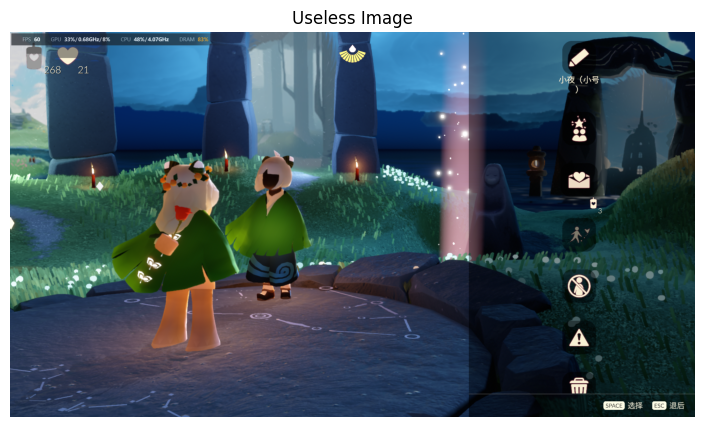



Processing frame.jpg...
检测为有效的星盘页
离散梯度切割超平面成功, 开始分类任务


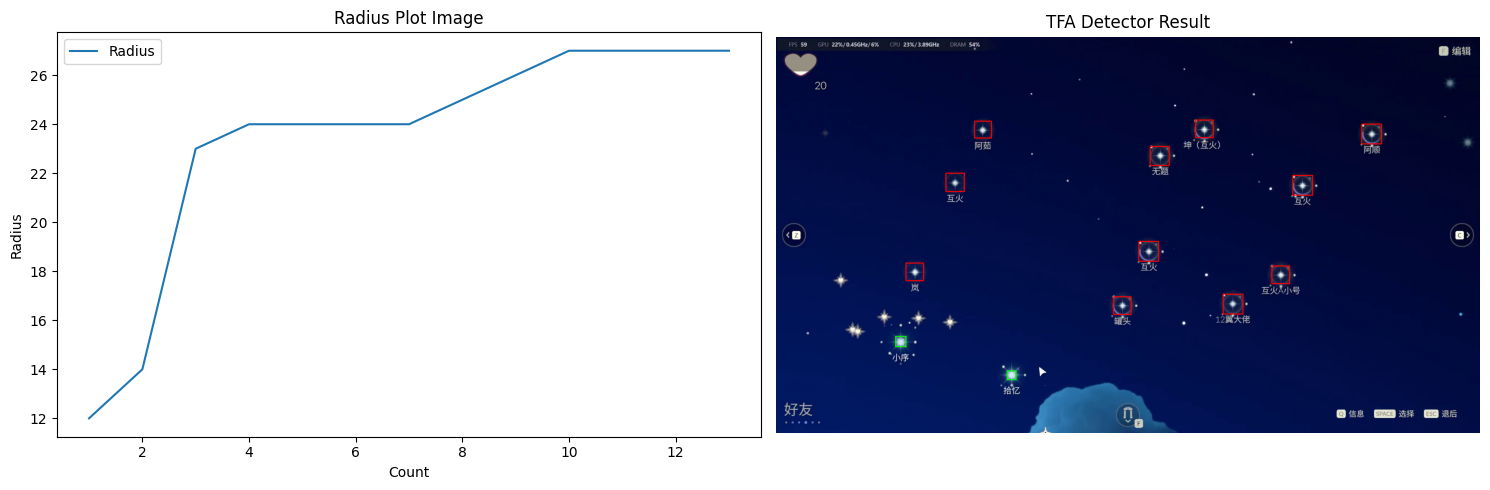



Processing frame2.jpg...
检测为有效的星盘页
离散梯度切割超平面成功, 开始分类任务


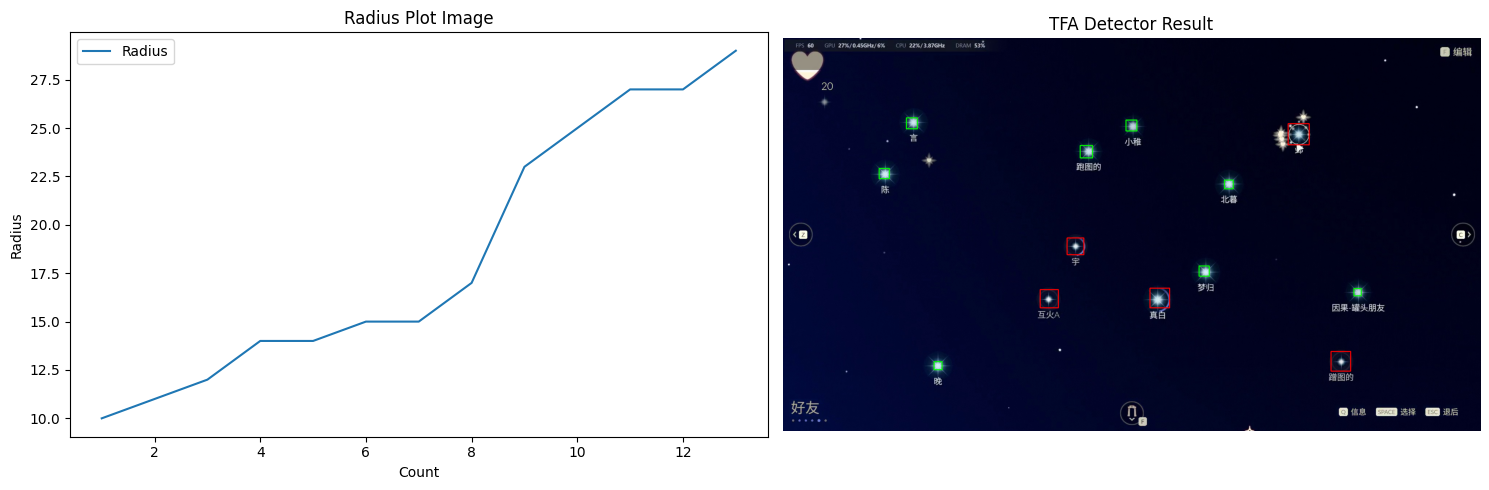



Processing frame3.jpg...
检测为有效的星盘页
离散梯度切割超平面成功, 开始分类任务


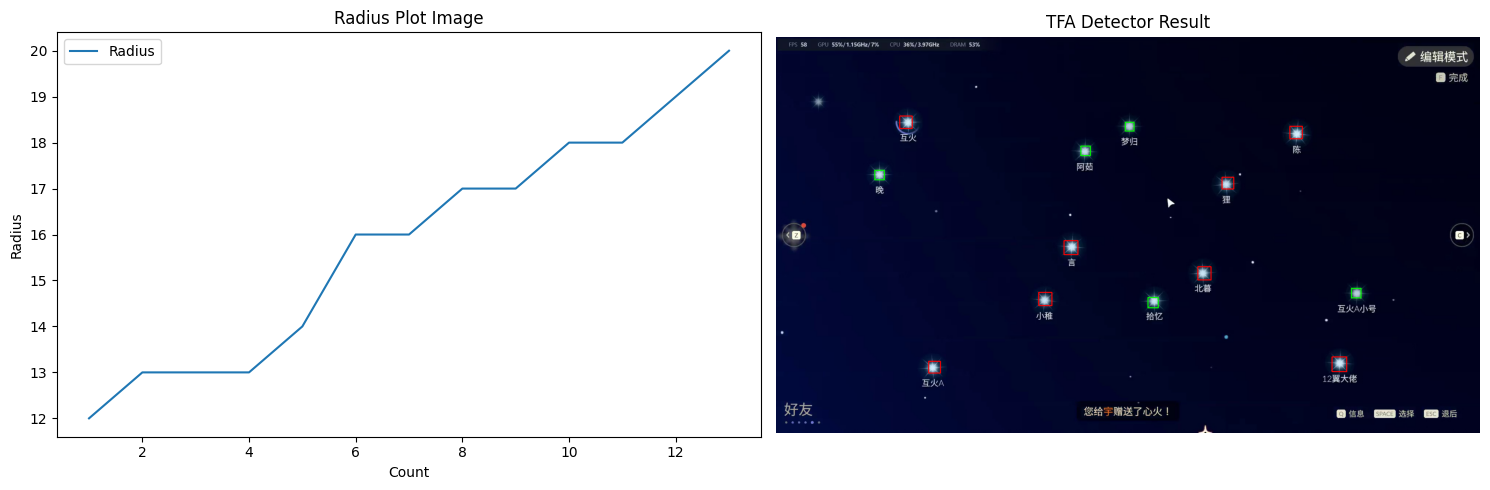



Processing main.png...
检测为有效的星盘页
离散梯度切割超平面失败, 将所有内容标注为待办


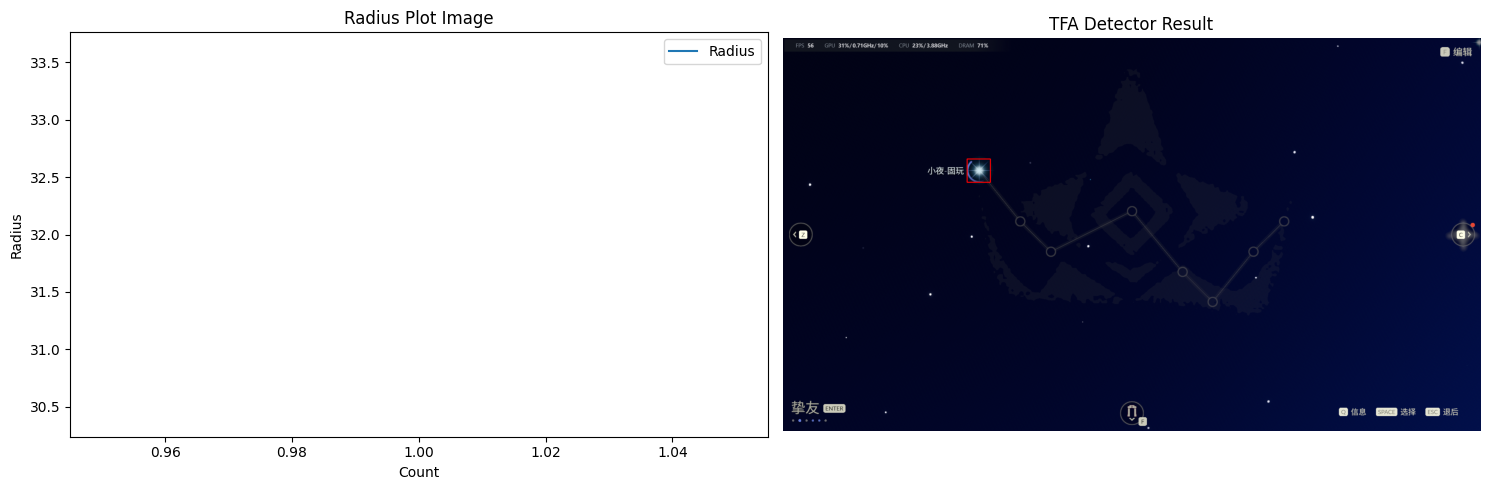



Processing main2.png...
检测为有效的星盘页
离散梯度切割超平面失败, 将所有内容标注为待办


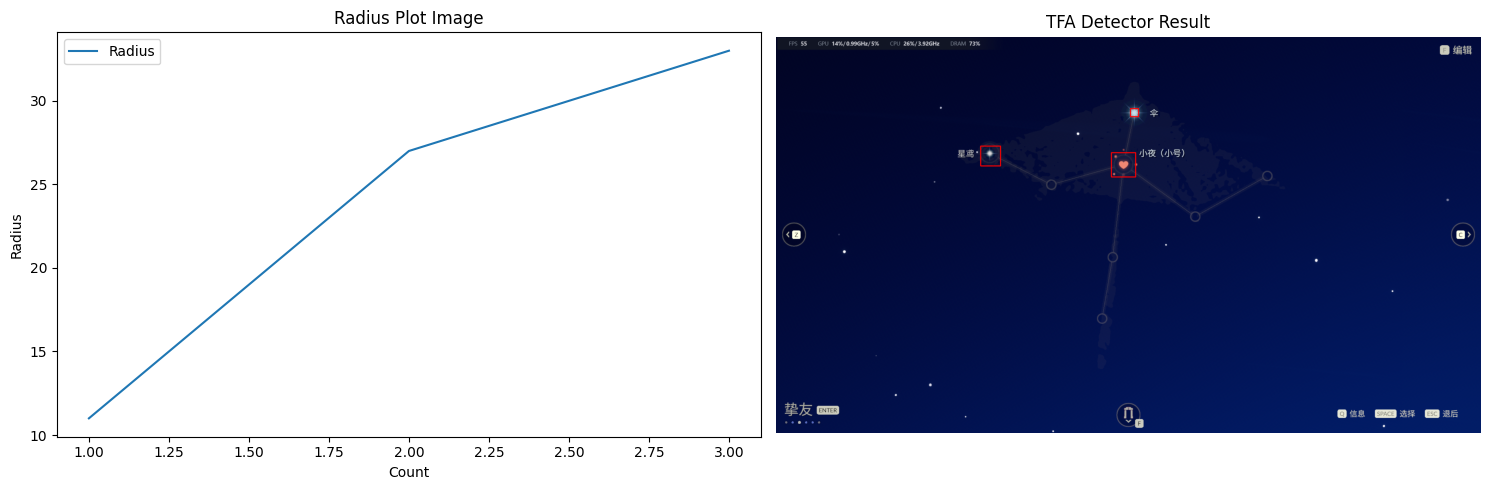



Processing page.png...
当前页面为添加好友页


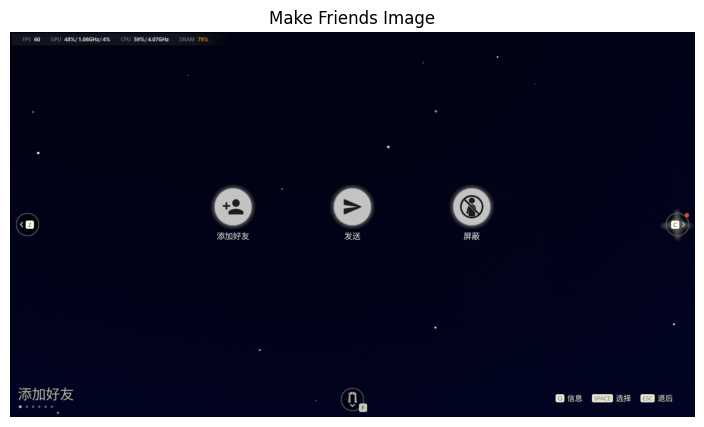



Processing receive.png...
不在星盘页, 不进行后续检测


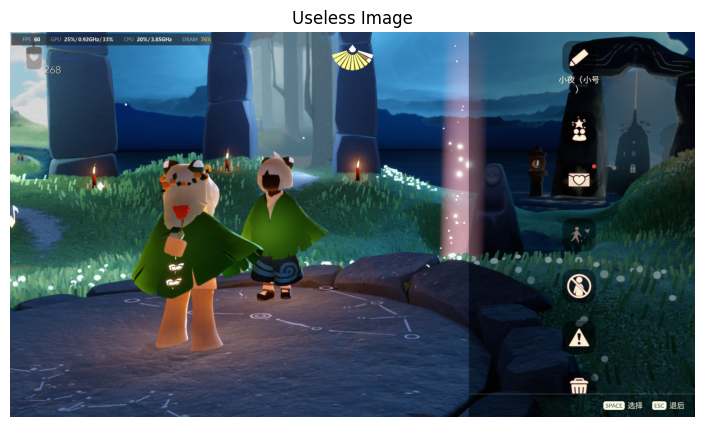



Processing side.png...
检测为有效的星盘页
离散梯度切割超平面成功, 开始分类任务


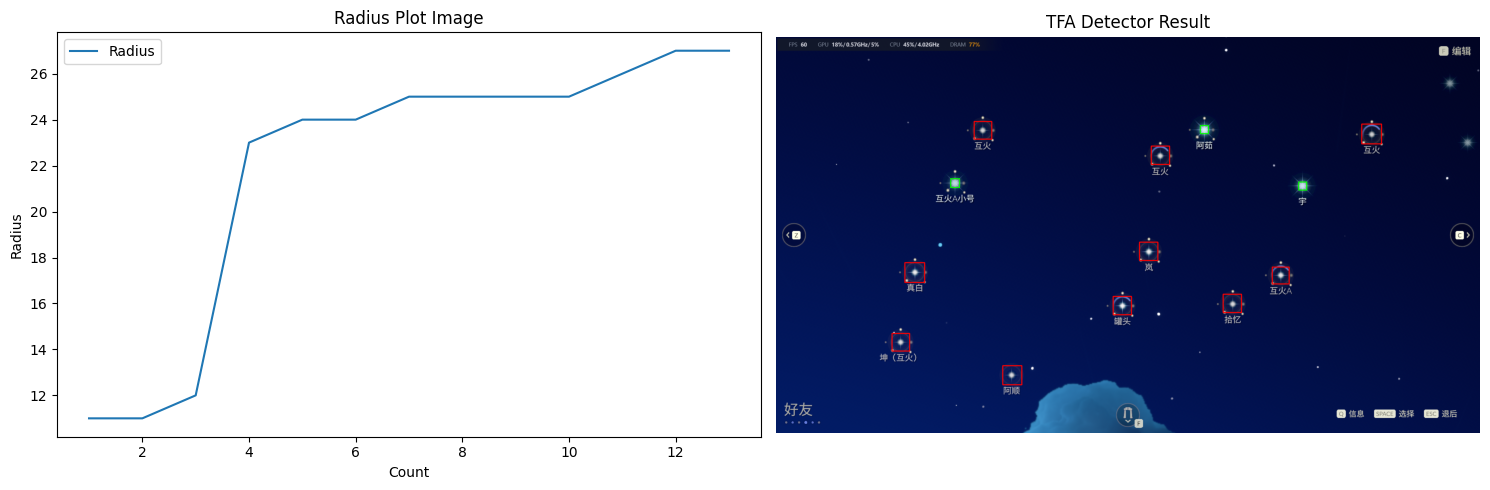



Processing side2.png...
检测为有效的星盘页
离散梯度切割超平面成功, 开始分类任务


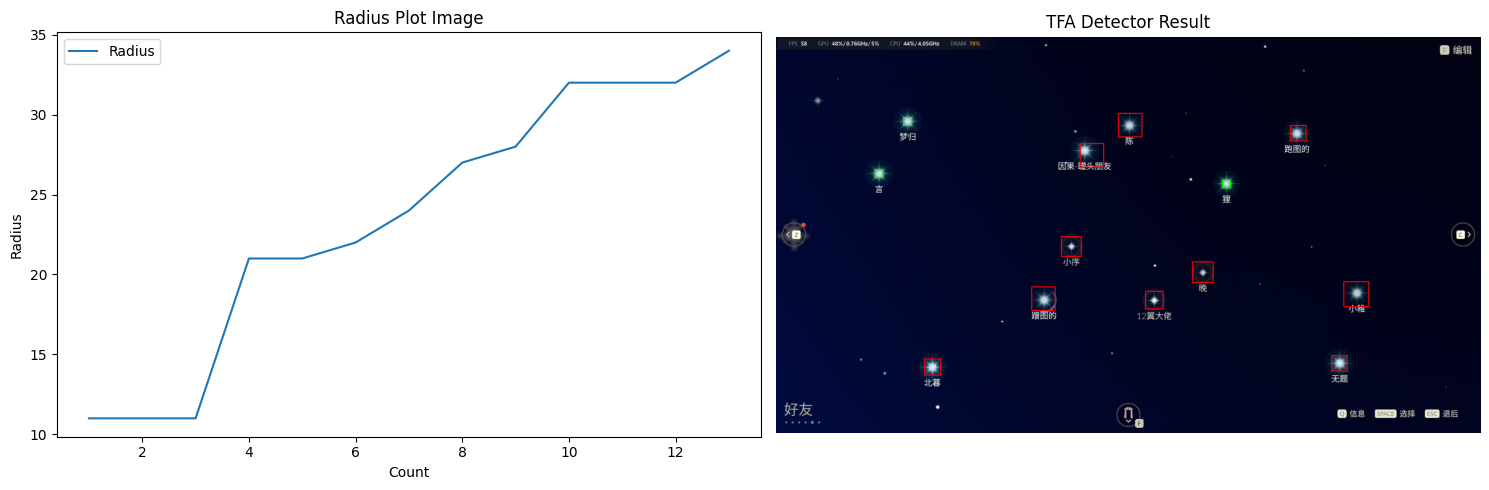



Processing side3.png...
检测为有效的星盘页
离散梯度切割超平面成功, 开始分类任务


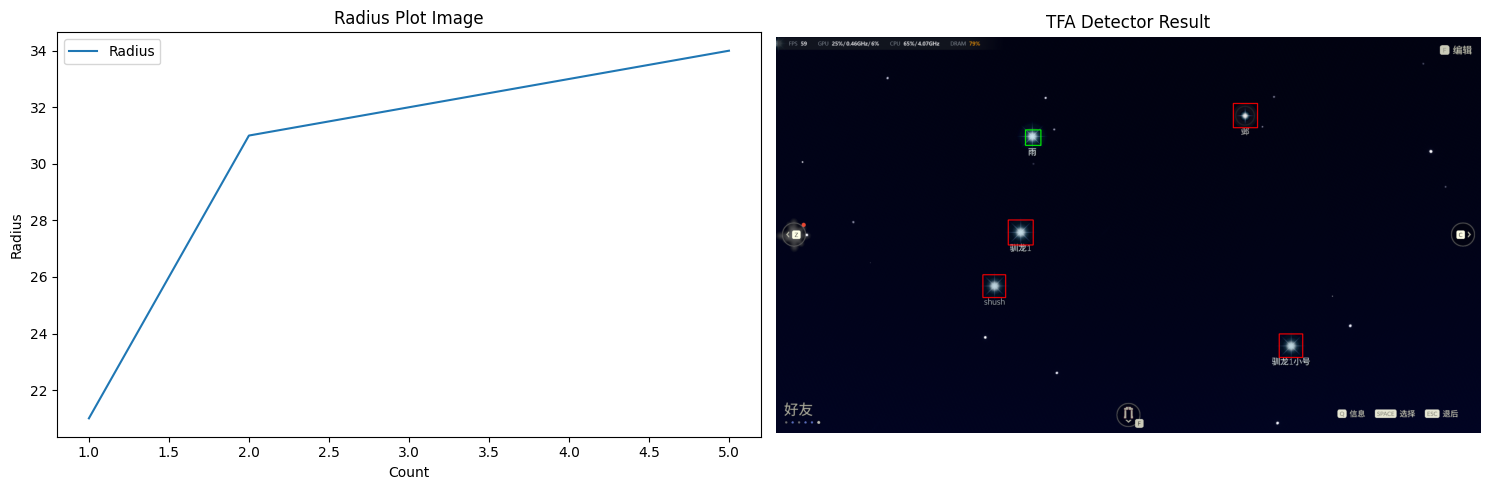

In [13]:
for filename in os.listdir(os.path.join("source", "data")):
    if filename.endswith(".png") or filename.endswith(".jpg"):
        print(f"\n\nProcessing {filename}...")
        
        image = cv2.imread(os.path.join("source", "data", filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        json_data, img = multi_detector(gray, plot=True, show=True)
    else:
        print(f"Skipping {filename}, not an image file.")

---
# 检测星星周围是否有星屑

检测为有效的星盘页
离散梯度切割超平面成功, 开始分类任务


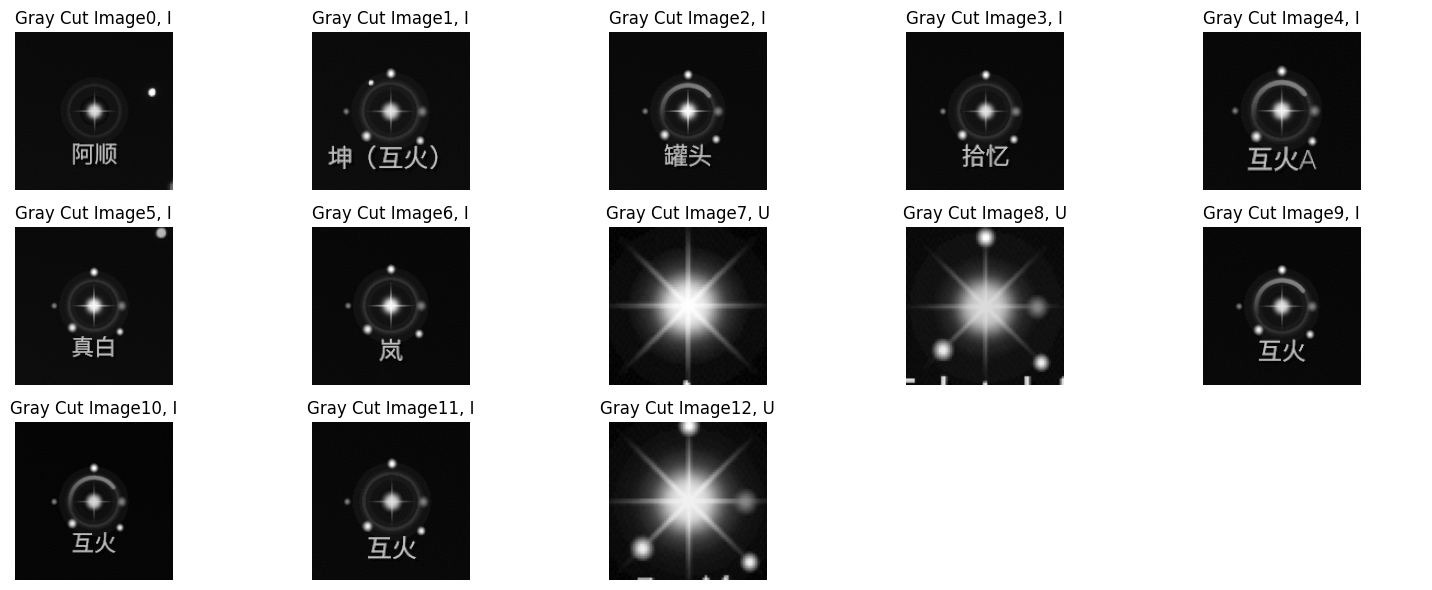

In [14]:
# 重新读取图片
image = cv2.imread(os.path.join("source", "data", "side.png"))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

pdata, img = multi_detector(gray, plot=True, show=False)

tfa_targets = pdata['tfa_targets']
sub_gray = [[gray[y-r*3:y+r*3, x-r*3:x+r*3], s] for (x, y, w, h), (cx, cy, r), s in tfa_targets]

fig, axes = plt.subplots(3, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flatten()):
    if i < len(sub_gray):
        ax.imshow(sub_gray[i][0], cmap='gray')
        ax.set_title('Gray Cut Image{}, {}'.format(i, sub_gray[i][1]))
    ax.axis('off')
plt.tight_layout()
plt.show()